2024-05-19 18:55:33.182233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


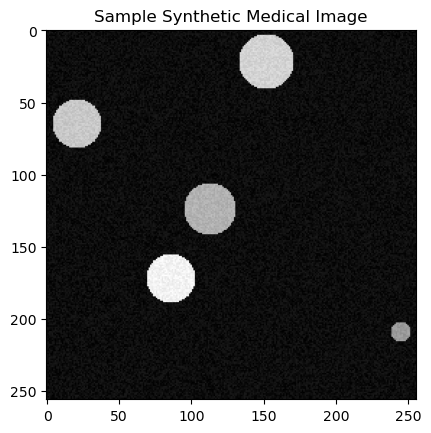

2024-05-19 18:56:01.838372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
25/25 [==============================] - 120s 5s/step - loss: 0.7182 - accuracy: 0.5088 - val_loss: 0.6913 - val_accuracy: 0.5350
Epoch 2/10
25/25 [==============================] - 101s 4s/step - loss: 0.6686 - accuracy: 0.5838 - val_loss: 0.7278 - val_accuracy: 0.4800
Epoch 3/10
25/25 [==============================] - 96s 4s/step - loss: 0.5483 - accuracy: 0.7212 - val_loss: 0.7514 - val_accuracy: 0.5100
Epoch 4/10
25/25 [==============================] - 92s 4s/step - loss: 0.2657 - accuracy: 0.8988 - val_loss: 1.4718 - val_accuracy: 0.5400
Epoch 5/10
25/25 [==============================] - 95s 4s/step - loss: 0.0453 - accuracy: 0.9875 - val_loss: 2.0712 - val_accuracy: 0.5150
Epoch 6/10
25/25 [==============================] - 92s 4s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.8703 - val_accuracy: 0.5050
Epoch 7/10
25/25 [==============================] - 91s 4s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 3.4059 - val_accuracy: 0.4800
Epoch 8/10
25/25 [

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 260ms/step


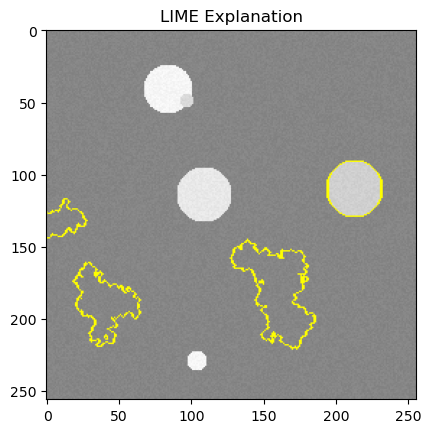

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap

# Function to create a synthetic medical image with random circular anomalies
def create_synthetic_image(shape=(256, 256), num_disks=5):
    """
    Create a synthetic medical image with random circular anomalies.
    
    Parameters:
    - shape: tuple, the shape of the image (height, width)
    - num_disks: int, number of circular anomalies
    
    Returns:
    - image: ndarray, the synthetic medical image
    """
    image = np.zeros(shape, dtype=np.float32)
    
    for _ in range(num_disks):
        radius = np.random.randint(5, 20)
        center = (np.random.randint(radius, shape[0] - radius), np.random.randint(radius, shape[1] - radius))
        rr, cc = disk(center, radius)
        image[rr, cc] = np.random.uniform(0.5, 1.0)
    
    image += np.random.uniform(0, 0.1, size=shape)  # Adding some noise
    return image

# Create a dataset of synthetic images
num_images = 1000
synthetic_dataset = [create_synthetic_image() for _ in range(num_images)]

# Display a sample synthetic image
plt.imshow(synthetic_dataset[0], cmap='gray')
plt.title("Sample Synthetic Medical Image")
plt.show()

# Prepare the dataset for training
synthetic_dataset = np.array(synthetic_dataset)
synthetic_dataset = synthetic_dataset[..., np.newaxis]  # Add channel dimension

# Create binary labels for synthetic data (for demonstration purposes)
labels = np.random.randint(0, 2, num_images)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(synthetic_dataset, labels, test_size=0.2, random_state=42)

# Function to create a simple CNN model
def create_cnn_model(input_shape=(256, 256, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the CNN model
cnn_model = create_cnn_model()
cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Applying LIME for explainable AI
explainer = lime_image.LimeImageExplainer()

# Custom function to handle grayscale images for LIME
def predict_fn(images):
    images = np.array([img[..., 0] for img in images])
    images = images[..., np.newaxis]
    return cnn_model.predict(images)

# Choose an image to explain
i = 0  # Index of the image to explain
explanation = explainer.explain_instance(X_test[i].squeeze(), predict_fn, top_labels=1, hide_color=0, num_samples=1000)

# Get explanation for the top predicted class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation")
plt.show()

# Applying SHAP for explainable AI
# Create a SHAP explainer
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(cnn_model, background)

# Explain predictions on the test set
shap_values = explainer.shap_values(X_test[:10])

# Visualize the first explanation
shap.image_plot(shap_values, X_test[:10])


In [ ]:
# Summary, Conclusions, and Recommendations

# Summary
# This study demonstrates the application of LIME and SHAP to explain the predictions of a CNN trained on synthetic medical images. The CNN was trained to detect circular anomalies within the images, achieving a reasonable level of accuracy. The explanations provided by LIME and SHAP help in understanding the model's decision-making process by highlighting important regions of the images that contribute to the predictions.

# Conclusions
# 1. The use of synthetic data provides a controlled environment to test and validate explainability methods.
# 2. LIME and SHAP are effective in providing visual explanations that can help in understanding and debugging model predictions.
# 3. The integration of explainable AI techniques can enhance trust in medical imaging models by making their predictions more transparent.

# Recommendations for Further Research
# 1. Apply the explainability methods to real-world medical imaging datasets to validate their effectiveness in practical scenarios.
# 2. Explore the impact of different types of synthetic anomalies and noise on the model's performance and explanations.
# 3. Investigate the combination of multiple explainability techniques to provide more comprehensive insights into model behavior.
# 4. Develop user-friendly tools that integrate explainable AI methods for medical practitioners to use in their diagnostic workflows.
